# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:
* Use modified sampling techniques to address class imbalance problems
* Understand the complications of class imbalance problems

## Predicting Credit Card Fraud
Load the **creditcard.csv.gz** file and preview the data. To load a compressed csv, use the optional parameter `compression='gzip'` within pandas read_csv method as in: `pd.read_csv(filename, compression='gzip')`.

In [1]:
#Your code here
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN


df = pd.read_csv('creditcard.csv.gz', compression='gzip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

You should see that the dataset has 31 columns. The first is a time field followed by V1-V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary Class flag. This last column, Class, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is.

In [6]:
#Your code here
display(df.Class.value_counts(normalize=False))
display(df.Class.value_counts(normalize=True))

0    284315
1       492
Name: Class, dtype: int64

0    0.998273
1    0.001727
Name: Class, dtype: float64

## Define the Problem

Define X and y and perform a standard train test split.

In [7]:
#Your code here
X = df[df.columns[:-1]]
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print('TRAIN')
display(y_train.value_counts(normalize=False))
display(y_train.value_counts(normalize=True))
print('Test')
display(y_test.value_counts(normalize=False))
display(y_test.value_counts(normalize=True))

TRAIN


0    213233
1       372
Name: Class, dtype: int64

0    0.998258
1    0.001742
Name: Class, dtype: float64

Test


0    71082
1      120
Name: Class, dtype: int64

0    0.998315
1    0.001685
Name: Class, dtype: float64

## Create an initial model

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

AUC: 0.884141085882033


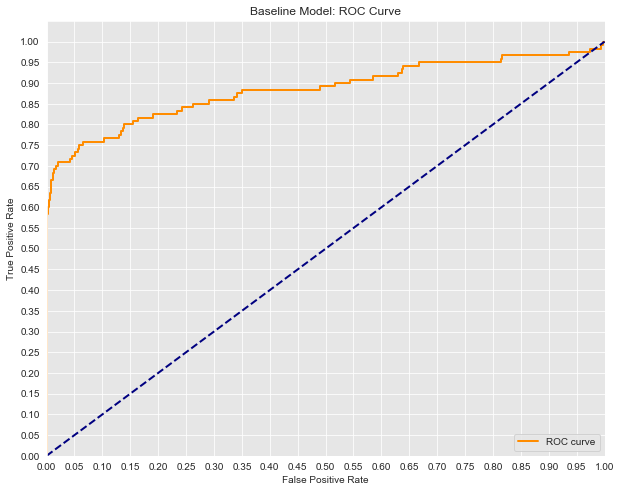

In [8]:
#Your code here
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

y_score = logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model: ROC Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix (not normalized):
[[71026    56]
 [   53    67]]


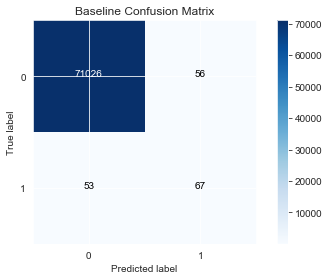

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix:')
    else:
        print('Confusion Matrix (not normalized):')

    print(cm)    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.colorbar()
    
y_hat_test = logreg.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cm_baseline, classes=[0, 1], normalize=False, title='Baseline Confusion Matrix')

## Tuning 
Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for None: 0.8841631261547696
LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for Balanced: 0.9767744764262869
LogisticRegression(C=1000000000000.0, class_weight={1: 2, 0: 1}, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for 2 to 1: 0.9050848550500361
LogisticRegression(C=1000000000000.

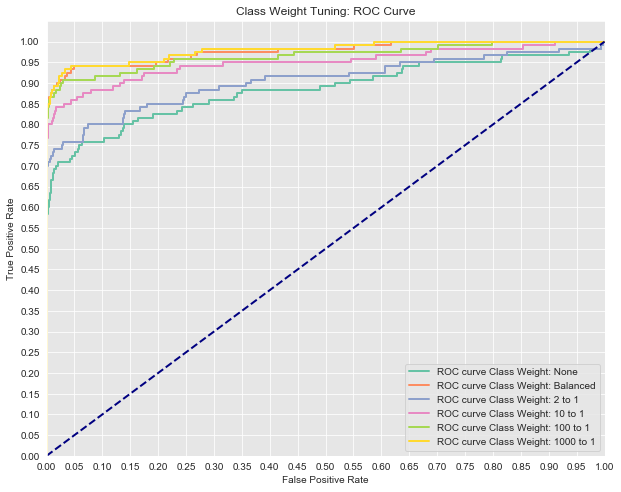

In [16]:
#Your code here
# Class Weight Tuning
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']

colors = sns.color_palette("Set2")

plt.figure(figsize=(10, 8))
for n, weight in enumerate(weights):
    logreg = LogisticRegression(fit_intercept=False, C=1e12, class_weight=weight, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Class Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class Weight Tuning: ROC Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix (not normalized):
[[67326  3756]
 [    7   113]]


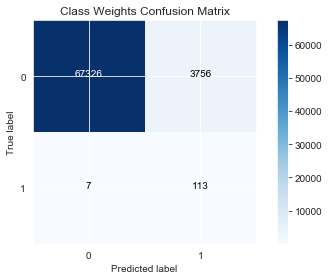

In [17]:
cm_classweights = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cm_classweights, classes=[0, 1], normalize=False, title='Class Weights Confusion Matrix')

LogisticRegression(C=0.001, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.001: 0.8397641690817178
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
AUC for 0.01: 0.8817811354023053
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
AUC for 0.1: 0.8839372133592189
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          in

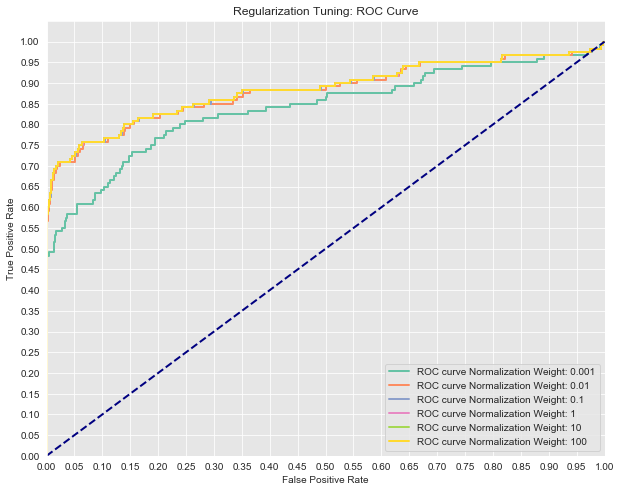

In [18]:
# Regularization Parameter (Normalization Weight) Tuning
C_params = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10, 8))
for n, c in enumerate(C_params):
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    y_hat_test = logreg.predict(X_test)
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Regularization Tuning: ROC Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix (not normalized):
[[71026    56]
 [   53    67]]


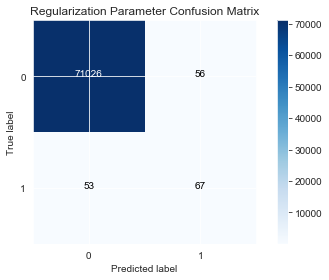

In [19]:
cm_regularization = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cm_regularization, classes=[0, 1], normalize=False, title='Regularization Parameter Confusion Matrix')

### SMOTE
If you haven't already, try using the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

In [21]:
#Your code here
from imblearn.over_sampling import SMOTE

print(y.value_counts(normalize=False)) 
print(y.value_counts(normalize=True))
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts(normalize=False))
print(pd.Series(y_train_resampled).value_counts(normalize=True))

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64
1    213233
0    213233
dtype: int64
1    0.5
0    0.5
dtype: float64


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.1: 0.9339428406628965
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.25: 0.9073144396612363
LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.33: 0.9356802706733068
LogisticRegression(C=1000000000000.0, class_weight=None,

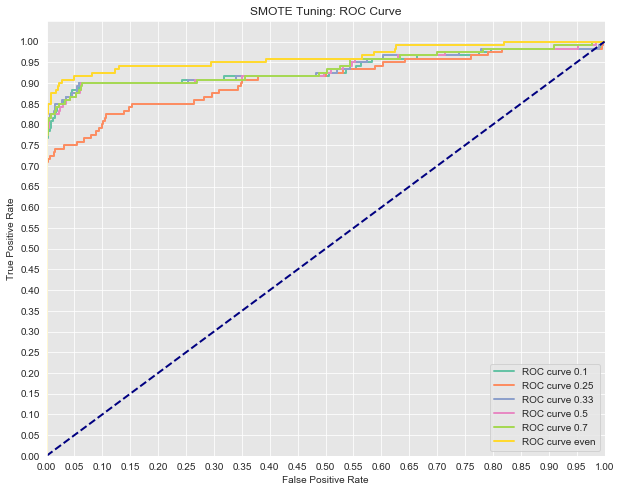

In [22]:
# SMOTE Minority Class Tuning
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33', '0.5', '0.7', 'even']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10, 8))
for n, ratio in enumerate(ratios):
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
    
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver ='liblinear') 
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) 

    y_hat_test = logreg.predict(X_test)
    y_score = logreg.decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SMOTE Tuning: ROC Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix (not normalized):
[[69631  1451]
 [   14   106]]


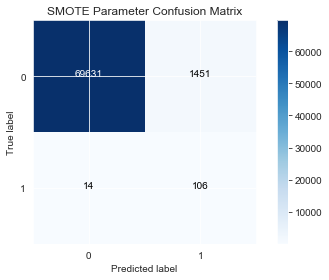

In [23]:
cm_smote = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(cm_smote, classes=[0, 1], normalize=False, title='SMOTE Parameter Confusion Matrix')

## Analysis
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
1    284315
0    284315
dtype: int64
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.005: 0.992261982457822
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.9922559800919245
LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn'

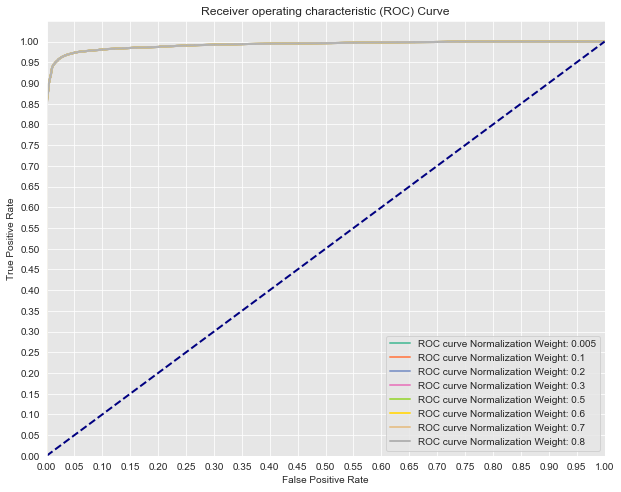

In [14]:
print(y.value_counts()) #Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c, solver='liblinear') #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Your response here
What is misleading about the AUC score and ROC curves produced by the code above is that the test set has been manipulated by the SMOTE oversampling techniqe. This alteration prevents an unbiased assessment of model performance due to the insertion of synethic test cases. As a result, the produced models will not generalize well.
Another curiosity is that the regularization parameter C is adjusted in the code that has been modified by SMOTE. It would seem more reasonable to adjust the minority case ratio within the applied SMOTE technique.

## Summary

In this lab, you got some hands-on practice tuning logistic regression models using various techniques and parameters. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.